In [1]:
import cv2
import numpy as np

from PIL import Image, ImageDraw, ImageFont

import imutils
from imutils import paths
from pylab import imread
from matplotlib import pyplot as plt

from skimage.util import img_as_ubyte
from skimage.color import rgb2gray
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


In [13]:
def ShowImage(ImageList, nRows=None, nCols=None, 
              WidthSpace=0.00, HeightSpace=0.00):
    
    if nRows is None and nCols is None:
        nRows = len(ImageList)
        nCols = 1
        
    assert (nRows == len(ImageList) or nCols == len(ImageList)), "Number of images mismatches number of gridspec"
    
    from matplotlib import pyplot as plt 
    from matplotlib import gridspec
    
    gs = gridspec.GridSpec(nRows, nCols)     
    gs.update(wspace=WidthSpace, 
              hspace=HeightSpace) # set the spacing between axes.
    plt.figure(figsize=(20, 10))
    for i in range(len(ImageList)):
        ax1 = plt.subplot(gs[i])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')

        plt.subplot(nRows, nCols, i+1)

        image = ImageList[i].copy()
        try:
            img_shape = len(image.shape)
        except AttributeError:
            img_shape = len(image.size)
        if (img_shape < 3):
            plt.imshow(image, plt.cm.gray)
        else:
            plt.imshow(image)
        plt.title("Image " + str(i))
        plt.axis('off')

    plt.show()
    return True


In [2]:
def AnalysisOnLabels(im, mask,
                     ColList=["label", "at_row", "at_col", "area"]):
    import pandas as pd
    from skimage.measure import label, regionprops

    label_img = label(mask)
    regions = regionprops(label_img,
                          intensity_image=im,
                          coordinates='rc')

    LabelDF = pd.DataFrame(columns=ColList)
    for props in regions:
        RowList = []

        label = props.label
        if ("label" in ColList):
            RowList.append(label)

        at_row, at_col = props.centroid
        if ("at_row" in ColList):
            RowList.append(at_row)

        if ("at_col" in ColList):
            RowList.append(at_col)

        if ("orientation" in ColList):
            RowList.append(props.orientation)

        if ("minor_axis_length" in ColList):
            RowList.append(props.minor_axis_length)

        if ("major_axis_length" in ColList):
            RowList.append(props.major_axis_length)

        if ("area" in ColList):
            RowList.append(props.area)

        if ("filled_area" in ColList):
            RowList.append(props.filled_area)

        if ("bbox_area" in ColList):
            RowList.append(props.bbox_area)

        if ("perimeter" in ColList):
            RowList.append(props.perimeter)

        minr, minc, maxr, maxc = props.bbox
        if ("minr" in ColList):
            RowList.append(minr)

        if ("minc" in ColList):
            RowList.append(minc)

        if ("maxr" in ColList):
            RowList.append(maxr)

        if ("maxc" in ColList):
            RowList.append(maxc)

        if ("width" in ColList):
            RowList.append(maxc - minc)

        if ("height" in ColList):
            RowList.append(maxr - minr)

        if ("eccentricity" in ColList):
            RowList.append(props.eccentricity)

        if ("equivalent_diameter" in ColList):
            RowList.append(props.equivalent_diameter)

        if ("euler_number" in ColList):
            RowList.append(props.euler_number)

        if ("extent" in ColList):
            RowList.append(props.extent)

        if ("solidity" in ColList):
            RowList.append(props.solidity)

        if ("max_intensity" in ColList):
            RowList.append(props.max_intensity)

        if ("mean_intensity" in ColList):
            RowList.append(props.mean_intensity)

        if ("min_intensity" in ColList):
            RowList.append(props.min_intensity)

        LabelDF.loc[label-1, 0:len(RowList)] = RowList
    return LabelDF, label_img


In [3]:
def IncreaseDescreaseMask_Circle(Mask, Size=2):
    from skimage.morphology import erosion, dilation
    # from skimage.morphology import opening, closing, white_tophat
    from skimage.morphology import disk

    selem = disk(abs(Size))
    if (Size > 0):
        result = dilation(Mask, selem)
    else:
        result = erosion(Mask, selem)
    return result


In [4]:
def IncreaseDescreaseMask_Square(Mask, Size=2):
    from skimage.morphology import erosion, dilation
    # from skimage.morphology import opening, closing, white_tophat
    from skimage.morphology import square

    if (Size > 0):
        result = dilation(Mask, square(abs(Size)))
    else:
        result = erosion(Mask, square(abs(Size)))
    return result


In [5]:
def FillHoles(Mask):
    from scipy import ndimage as ndi
    return ndi.binary_fill_holes(Mask)


In [9]:
def SelectMaskByThreshArea(Mask, minArea=300):
    import pandas as pd
    from skimage.measure import label, regionprops

    mask = Mask.copy()
    mask_output = mask * 0
    bboxList = []

    label_img = label(mask)
    regions = regionprops(label_img)
    for props in regions:
        area = props.area
        label = props.label
        if (area > minArea):
            mask_output = mask_output + (label_img==label).astype(int)

    return mask_output


In [8]:
def SelectTheMaxAreaByOrder(Mask, Order=[1]):
    Mask = IncreaseDescreaseMask_Circle(Mask, -2)
    LabelDF, label_img = AnalysisOnLabels(Mask, Mask, ColList=["label", "area"])
    LabelDF = LabelDF.sort_values(by="area", ascending=False)
    LabelDF = LabelDF.reset_index(drop=True)

    mask_output = Mask * 0
    for i in Order:
        if i in list(LabelDF["label"]):
            mask_output[label_img==LabelDF.loc[i-1, "label"]] = 1
    mask_output =  IncreaseDescreaseMask_Circle(mask_output, 3)
    return mask_output


In [19]:
def crop_defect_zone(image_origin,
                     relative_offset=(0.13, 0.99, 0.01, 0.6), #h,w
                     return_bbox=False,
                     crop_zone=[],
                     visual_check=False):
    image_color = image_origin.copy()
    if crop_zone == []:
        H, W = image_color.shape[:2]
        abs_offset = (int(relative_offset[0]*H),
                      int(relative_offset[1]*H),
                      int(relative_offset[2]*W),
                      int(relative_offset[3]*W),)
        image_cropped = image_color[abs_offset[0]:abs_offset[1],
                                    abs_offset[2]:abs_offset[3], :]
        # print(image_cropped.shape)
        green_channel = image_cropped[:, :, 1]
        image_cropped[green_channel>250] = [255, 255, 255]
        image_gray = np.uint8(cv2.cvtColor(image_cropped, cv2.COLOR_RGB2GRAY) * 255)
        image_segmented = image_gray > 100
        image_segmented = IncreaseDescreaseMask_Square(image_segmented, -11)
        image_segmented = IncreaseDescreaseMask_Square(image_segmented, 13)
        image_segmented = FillHoles(image_segmented)
        image_segmented = SelectMaskByThreshArea(image_segmented, minArea=10000)
        try:
            # defect_zone = image_color.copy()
            # defect_zone[image_segmented==0] = [255, 255, 255]
            defect_zone = image_segmented
            n_rows, n_cols = image_gray.shape[:2]
            row_list = []
            for row, arr in enumerate(defect_zone.T):
                nonzero_count = np.count_nonzero(arr==1)
                if n_rows > nonzero_count > int(n_rows/5):
                    row_list.append([row, nonzero_count])
            row_list = np.array(row_list)
            row_min = np.amin(row_list, axis=0)[0]
            row_max = np.amax(row_list, axis=0)[0]

            col_list = []
            for col, arr in enumerate(defect_zone):
                nonzero_count = np.count_nonzero(arr==1)
                if n_cols > nonzero_count > int(n_cols/5):
                    col_list.append([col, nonzero_count])
            col_list = np.array(col_list)
            col_min = np.amin(col_list, axis=0)[0]
            col_max = np.amax(col_list, axis=0)[0]

            defect_zone = image_color[col_min+abs_offset[0]:col_max+abs_offset[0],
                                      row_min+abs_offset[2]:row_max+abs_offset[2]]

        except Exception as e:
            print(e)
            defect_zone = None

        if visual_check:
            ShowImage([image_gray], 1, 1)
            ShowImage([image_segmented], 1, 1)
            ShowImage([defect_zone], 1, 1)

        if return_bbox:
            return defect_zone, [row_min+abs_offset[2], col_min+abs_offset[0],
                                 row_max+abs_offset[2], col_max+abs_offset[0]]
        else:
            return defect_zone
    elif len(crop_zone) == 4:
        [col_min, col_max, row_min, row_max] = crop_zone
        defect_zone = image_color[col_min:col_max, row_min:row_max, :]
        return defect_zone
    

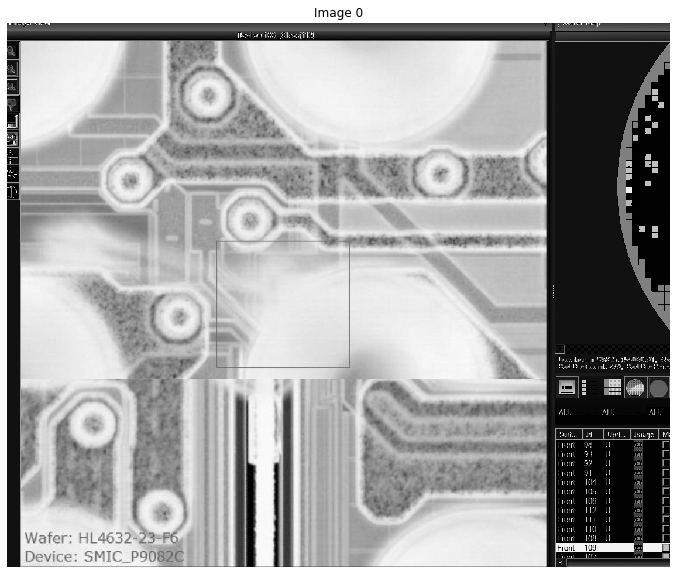

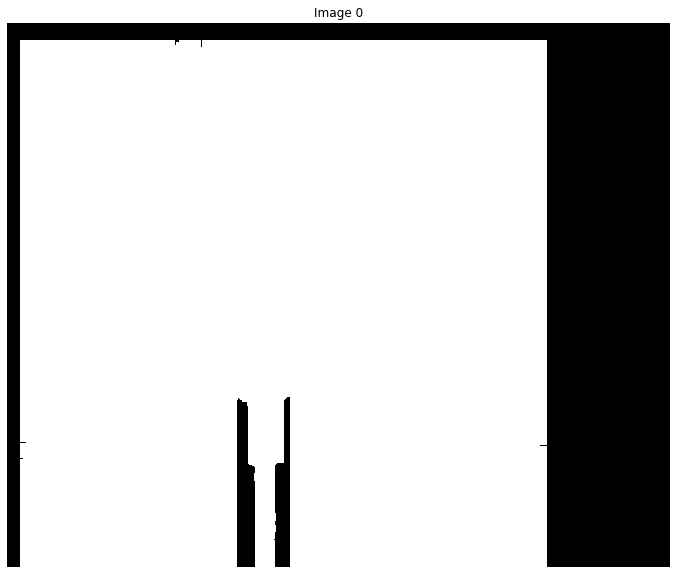

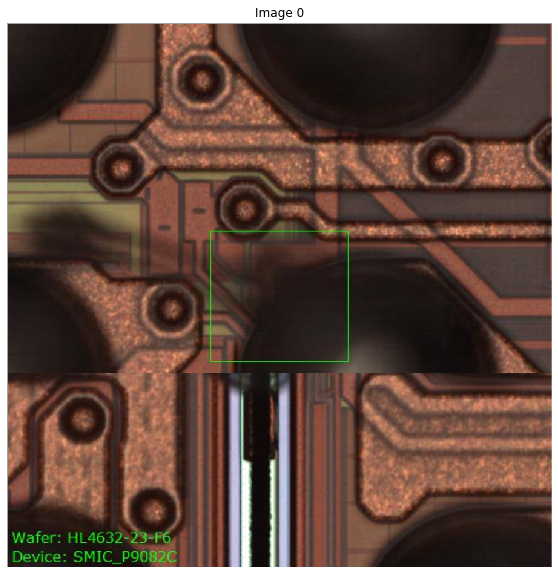

In [20]:
image_path = r"D:\HARI\__RL_Dev__\__Backend_RL__\Environments\states\SCS\s_14.png"
image = Image.open(image_path)

image_arr = np.asarray(image)
defect, bbox = crop_defect_zone(image_arr.copy(), return_bbox=True, visual_check=True)


In [21]:
bbox

[41, 169, 941, 1068]